In [11]:
import matplotlib.lines as mlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import glob
sns.set_palette("colorblind")

warnings.filterwarnings('ignore')



In [12]:
column_our_method = ['dataset', 'method',  'runtime',
                     'mrr',  'All_RecallAtSizeofGroundTruth', 'All_F1Score']

column_other_methods = ['dataset',  'matcher', 'runtime',
                        'MRR',  'RecallAtSizeofGroundTruth', 'F1Score']


def load_other_methods(path):
    df = pd.read_csv(path)

    df['runtime'] = df['runtime'].apply(lambda x: x/1000)

    df['dataset'] = df['taskname'].apply(lambda x: x.split('/')[-1])

    df = df[column_other_methods]
    df.columns = column_our_method

    return df


def load_our_methods(path):
    df = pd.read_csv(path)

    

    df['dataset'] = df['source_table'].apply(lambda x: x.replace('.csv', '').lower())

    df = df[column_our_method]

    df = df[df['method'] != 'ComaInst']

    df['method'] = df['method'].apply(lambda x: x.replace('MatchMaker', 'Magneto ') if 'MatchMaker' in x else x)

    return df

In [13]:
def fix_df(df):



    df = df.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'})
    df = df.rename(columns={'All_F1Score': 'F1'})
    df = df.rename(columns={'mrr': 'MRR'})

    df = df.round(3)

    return df

In [14]:
metrics = ['MRR', 'Recall@GT']


def plot(df, ax, metric):

    x = sorted(df['dataset'].unique())

    sns.barplot(
        palette=sns.color_palette("Set2"),  # Use a better palette
        x='method',
        y=metric,
        data=df,
        ax=ax
    )

    # sns.boxplot(
    #     palette=sns.color_palette("Set2"),  # Use a better palette
    #     x='method',
    #     y=metric,
    #     data=df,
    #     ax=ax,
    #     showfliers=False,
    #     width=0.5
    # )
    # ax.set_title(f'{metric} by Dataset and Method')
    ax.set_xlabel(None)
    ax.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax.set_ylabel(metric, fontsize=14)

    ax.set_ylim(-0.01, 1.01)



    


def plot_bars_all(df, figsize=(15, 5), metric_order= 'MRR', save=None):

    # Calculate the mean MRR per method
    mean_mrr = df.groupby('method')[metric_order].mean().sort_values(ascending=False)
    df['method_rank'] = df['method'].map(mean_mrr.rank(ascending=False))
    df = df.sort_values(by='method_rank')


    

    fig, axis = plt.subplots(len(metrics), 1, figsize=figsize, sharex=True)

    for i, metric in enumerate(metrics):
        plot(df, axis[i], metric)

    sns.despine()

    if save is not None:
        plt.savefig(save, dpi=300)

In [15]:
def analyze(df, metric, ascending=False):
    grouped = df.groupby('method')[metric].agg(['mean', 'median', 'min', 'max', 'std'])
    grouped = grouped.sort_values(by='mean', ascending=ascending)
    grouped = grouped.round(3)
    print('General stats')
    print(grouped)

    print('\n')

    grouped = df.groupby(['dataset', 'method'])[metric].agg(['mean', 'median', 'min', 'max', 'std'])
    
    grouped = grouped.groupby(level=0).apply(lambda x: x.sort_values(by='mean', ascending=ascending))

    grouped = grouped.round(3)
    print('Per dataset stats')
    print(grouped)


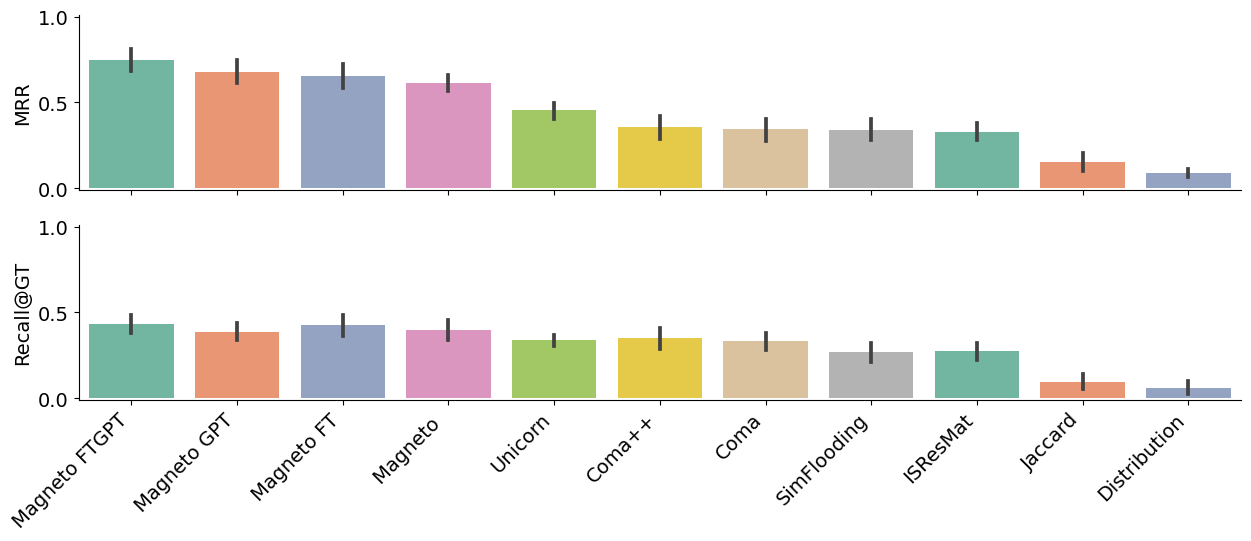

In [16]:
main_path = 'server_results/main_experiment_gdc/'
other_methods_path = main_path + 'results_gdc_new.csv'
our_method_path = main_path + 'gdc_studies_gdc_studies_results_20241126092316.csv'

df_other = load_other_methods(other_methods_path)
df_our = load_our_methods(our_method_path)

df = pd.concat([df_our, df_other])

df = fix_df(df)


plot_bars_all(df, save='figures/main_experiment_all_methods_gdc.pdf')
# plot_bars_all(df,metric_order='Recall@GT' ,save='figures/main_experiment_all_methods_gdc.pdf')




In [17]:
analyze(df, 'MRR')

General stats
                mean  median    min    max    std
method                                           
Magneto FTGPT  0.744   0.727  0.575  0.925  0.111
Magneto GPT    0.674   0.651  0.533  0.875  0.118
Magneto FT     0.652   0.628  0.479  0.825  0.118
Magneto        0.610   0.597  0.521  0.756  0.077
Unicorn        0.454   0.460  0.325  0.548  0.078
Coma++         0.358   0.388  0.118  0.500  0.108
Coma           0.346   0.342  0.118  0.500  0.107
SimFlooding    0.338   0.334  0.188  0.549  0.101
ISResMat       0.329   0.330  0.174  0.462  0.087
Jaccard        0.152   0.146  0.008  0.329  0.090
Distribution   0.088   0.063  0.048  0.169  0.042


Per dataset stats
                               mean  median    min    max  std
dataset dataset method                                        
cao     cao     Unicorn       0.548   0.548  0.548  0.548  NaN
                Coma          0.414   0.414  0.414  0.414  NaN
                Coma++        0.414   0.414  0.414  0.414  NaN
 

In [18]:
analyze(df, 'Recall@GT')

General stats
                mean  median    min    max    std
method                                           
Magneto FTGPT  0.430   0.438  0.286  0.621  0.092
Magneto FT     0.425   0.434  0.242  0.591  0.108
Magneto        0.394   0.390  0.242  0.591  0.102
Magneto GPT    0.386   0.352  0.286  0.545  0.086
Coma++         0.351   0.388  0.118  0.455  0.100
Unicorn        0.338   0.342  0.235  0.414  0.054
Coma           0.334   0.342  0.118  0.455  0.093
ISResMat       0.274   0.281  0.125  0.400  0.081
SimFlooding    0.270   0.293  0.088  0.409  0.092
Jaccard        0.097   0.097  0.000  0.227  0.072
Distribution   0.058   0.059  0.000  0.200  0.067


Per dataset stats
                               mean  median    min    max  std
dataset dataset method                                        
cao     cao     Coma          0.414   0.414  0.414  0.414  NaN
                Coma++        0.414   0.414  0.414  0.414  NaN
                Unicorn       0.414   0.414  0.414  0.414  NaN
 

In [19]:
analyze(df, 'runtime', ascending=True)

General stats
                  mean   median      min       max      std
method                                                     
Jaccard         14.083    7.736    1.673    66.898   19.538
Magneto         16.535   16.198   15.340    19.330    1.212
Magneto FT      16.991   16.646   15.274    19.456    1.299
Unicorn         37.330   34.585   15.115    62.170   13.167
Coma            93.405   46.022   16.460   462.320  133.643
Coma++         105.917   51.329   18.074   515.204  148.741
Distribution   130.591   86.395   40.834   489.474  131.955
Magneto FTGPT  160.403  111.786   60.000   474.419  123.689
Magneto GPT    193.678  134.836   63.180   672.285  178.411
SimFlooding    260.620  197.092   78.705   799.480  209.353
ISResMat       801.322  780.736  682.052  1116.870  123.619


Per dataset stats
                                 mean   median      min      max  std
dataset dataset method                                               
cao     cao     Jaccard         9.229    9.229

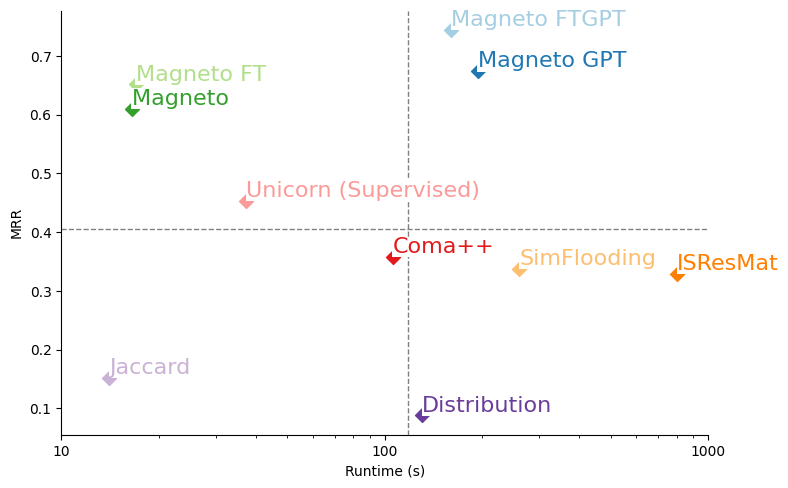

In [20]:
def pareto_plot_mean(df, metrics, filename):

    fig, ax = plt.subplots(figsize=(8, 5))

    # markers = ['o', 's', 'D', '^', 'v']
    markers = ['D']
    unique_matchers = df['matcher'].unique()
    marker_dict = {matcher: markers[i % len(markers)] for i, matcher in enumerate(unique_matchers)}

    palette = sns.color_palette("Paired", len(unique_matchers))



    
    right_anotations_matchers = [  'IsResMat (Self-Supervised)']


    for i, matcher in enumerate(unique_matchers):
        matcher_data = df[df['matcher'] == matcher]
        x = matcher_data[metrics[0]].values[0]
        y = matcher_data[metrics[1]].values[0]
        
        # Scatter plot for each matcher
        ax.scatter(x, y, label=matcher, color=palette[i], marker=marker_dict[matcher], s=50)

        if matcher in right_anotations_matchers:
            ax.text(
                x, y , matcher, fontsize=16, ha='right', va='bottom', color=palette[i],
                bbox=dict(facecolor='white', edgecolor='none', pad=0.3)
            )
        else:
            ax.text(
                x, y , matcher, fontsize=16, ha='left', va='bottom', color=palette[i],
                bbox=dict(facecolor='white', edgecolor='none', pad=0.3)
            )


    xlabel = metrics[0][0].upper() + metrics[0][1:]  # Capitalize the first letter
    ax.set_xlabel(xlabel)
    ax.set_ylabel(metrics[1].upper())  

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:g}'))
    ax.set_xticks([10, 100, 1000])
   

    #  quadrant lines based on median
    median_x = np.median(df[metrics[0]])
    median_y = np.median(df[metrics[1]])
    ax.axhline(median_y, color='grey', linestyle='--', linewidth=1)
    ax.axvline(median_x, color='grey', linestyle='--', linewidth=1)

    # Remove top and right borders
    sns.despine(ax=ax)


    ax.legend_.remove() if ax.get_legend() else None







    fig.savefig(filename+'.pdf', dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


df['matcher'] = df['method']
df['mrr'] = df['MRR']

df = df.groupby('matcher')[['mrr', 'runtime']].mean().reset_index()
df = df[df['matcher'] != 'Coma']
df = df.sort_values(by='mrr', ascending=False)

df['matcher'] = df['matcher'].replace({'Unicorn': 'Unicorn (Supervised)'})
# df['matcher'] = df['matcher'].replace({'ISResMat': 'IsResMat (Self-Supervised)'})


df.rename(columns={'runtime': 'runtime (s)'}, inplace=True)

metrics = ['runtime (s)', 'mrr']
pareto_plot_mean(df, metrics, filename='run_mrr_mean_pareto_gdc')